Escaneando scale_pos_weight (1-50) para: Scale Pos Weight...
Escaneando scale_pos_weight (1-50) para: SMOTE + Tomek...
Escaneando scale_pos_weight (1-50) para: SMOTE + ENN...
Escaneando scale_pos_weight (1-50) para: NearMiss...
Escaneando scale_pos_weight (1-50) para: ADASYN...


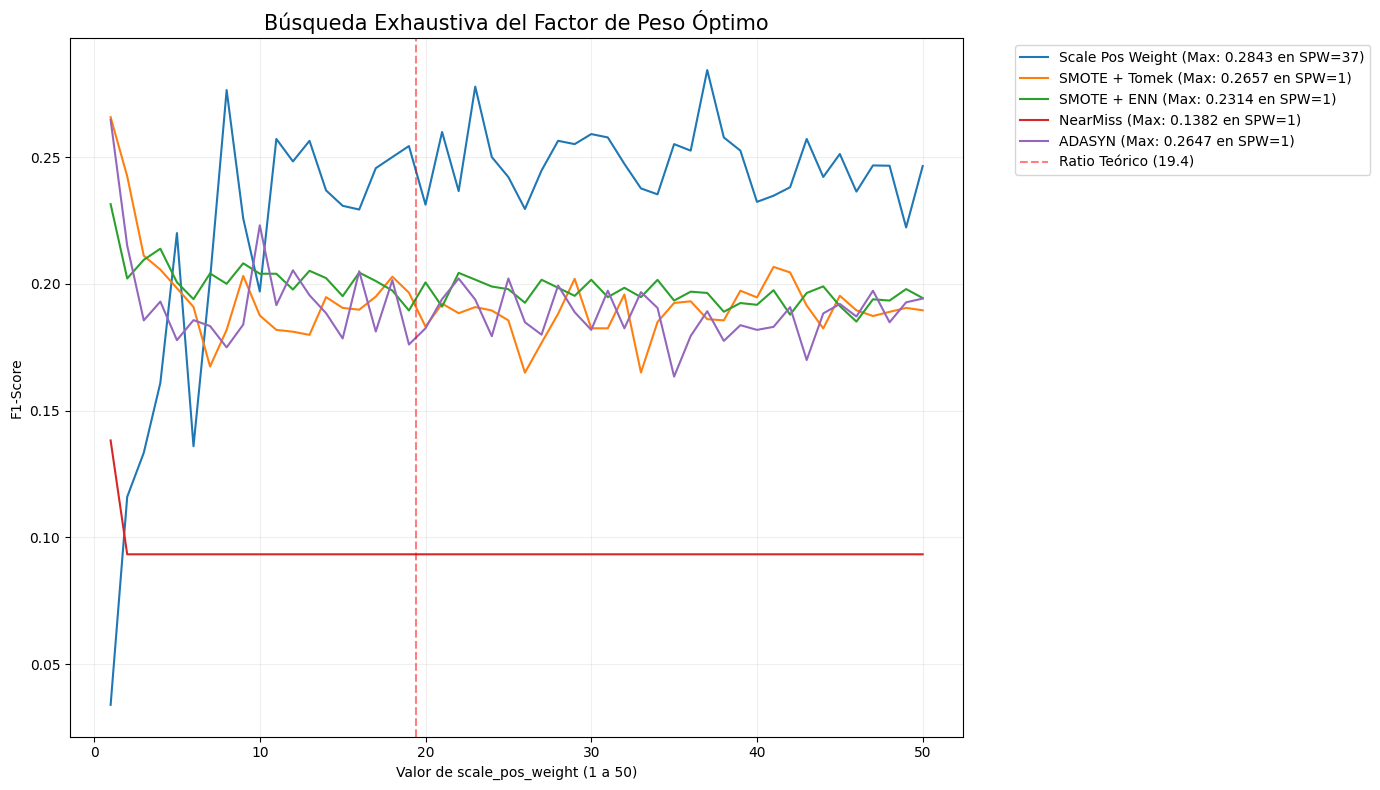


TÉCNICA              | BEST WEIGHT     | MAX F1  
-----------------------------------------------------------------
Scale Pos Weight     | 37              | 0.2843
SMOTE + Tomek        | 1               | 0.2657
SMOTE + ENN          | 1               | 0.2314
NearMiss             | 1               | 0.1382
ADASYN               | 1               | 0.2647


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. PREPARACIÓN DE DATOS
# Asegúrate de que la ruta 'dataset/...' sea correcta en tu entorno
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
df_final = pd.get_dummies(df, drop_first=True)
X = df_final.drop('stroke', axis=1)
y = df_final['stroke']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. CONFIGURACIÓN ACUMULADA (Fases 1 a 7)
config_fase7 = {
    'Scale Pos Weight': (None, 125, 0.1, 5, 1, 0, 0.9, 1.0),
    'SMOTE + Tomek': (SMOTETomek(random_state=42), 256, 0.15, 5, 3, 0.1, 1.0, 1.0),
    'SMOTE + ENN': (SMOTEENN(random_state=42), 171, 0.1, 5, 1, 0, 0.8, 1.0),
    'NearMiss': (NearMiss(), 271, 0.001, 4, 1, 0, 1.0, 1.0),
    'ADASYN': (ADASYN(random_state=42), 242, 0.15, 5, 1, 0, 1.0, 1.0)
}

# RANGO: De 1 a 50
spw_range = list(range(1, 51)) 
spw_final_results = []

plt.figure(figsize=(14, 8))

for nombre, (sampler, n_opt, lr_opt, d_opt, w_opt, g_opt, s_opt, c_opt) in config_fase7.items():
    spw_f1 = []
    
    if sampler is not None:
        X_res, y_res = sampler.fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
        
    print(f"Escaneando scale_pos_weight (1-50) para: {nombre}...")
    
    for s in spw_range:
        model = XGBClassifier(
            n_estimators=n_opt,
            learning_rate=lr_opt,
            max_depth=d_opt,
            min_child_weight=w_opt,
            gamma=g_opt,
            subsample=s_opt,
            colsample_bytree=c_opt,
            scale_pos_weight=s,
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss'
        )
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        spw_f1.append(f1_score(y_test, y_pred))
    
    # Identificar el punto máximo
    max_f1 = max(spw_f1)
    best_s = spw_range[spw_f1.index(max_f1)]
    
    # Guardamos con claves consistentes
    spw_final_results.append({
        'Técnica': nombre, 
        'Best_SPW': best_s, 
        'Max_F1': max_f1
    })
    
    plt.plot(spw_range, spw_f1, label=f"{nombre} (Max: {max_f1:.4f} en SPW={best_s})")

# 4. ESTÉTICA DE LA GRÁFICA
plt.title('Búsqueda Exhaustiva del Factor de Peso Óptimo', fontsize=15)
plt.xlabel('Valor de scale_pos_weight (1 a 50)')
plt.ylabel('F1-Score')
plt.axvline(x=19.4, color='red', linestyle='--', alpha=0.5, label='Ratio Teórico (19.4)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# 5. TABLA COMPARATIVA (Corregida)
print("\n" + "="*65)
print(f"{'TÉCNICA':<20} | {'BEST WEIGHT':<15} | {'MAX F1':<8}")
print("-"*65)
for r in spw_final_results:
    # Usamos las claves correctas definidas arriba
    print(f"{r['Técnica']:<20} | {r['Best_SPW']:<15} | {r['Max_F1']:.4f}")
print("="*65)